Sources:
https://www.geeksforgeeks.org/implement-convolutional-autoencoder-in-pytorch-with-cuda/#
    - Consists of encoder and decoder
        - Encoder: compresses input data into lower dimension representation
        - Decoder: expands the compressed data, aiming to perfectly replicate the input
    - Training: Minimize MSE between input of encoder and output of decoder
    
In this file, I train a convolutional autoencoder that takes images of the handwritten characters 4 and 7 from the MNIST dataset. The encoder portion of the CAE reduced the image (724, 1) into a lower dimension representation of each image (9,1), and then the decoder portion of the CAE upsampled the lower dimension representation (9,1) into the original shape (724, 1). The mean squared error was taken between the original image and the decoded representation vector. Using the representation vector, kernel SVM was run to classify each image as either the number 4 or 7. Using both of these models resulted in an accuracy of 100 percent.


In [118]:
import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

tensor_transform = transforms.ToTensor()
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=tensor_transform)

# Filter dataset to only include digits 4 and 7
indices = [i for i, (img, label) in enumerate(dataset) if label in [4, 7]]
subset = torch.utils.data.Subset(dataset, indices)

loader = torch.utils.data.DataLoader(dataset=subset, batch_size=1000, shuffle=True)


In [119]:
class Auto_Encoder(nn.Module):
    def __init__(self):
        super(Auto_Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9)
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [120]:
model = Auto_Encoder()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

Epoch 1/200, Loss: 0.081196
Epoch 2/200, Loss: 0.070659
Epoch 3/200, Loss: 0.066342
Epoch 4/200, Loss: 0.061492
Epoch 5/200, Loss: 0.064058
Epoch 6/200, Loss: 0.064273
Epoch 7/200, Loss: 0.062773
Epoch 8/200, Loss: 0.064594
Epoch 9/200, Loss: 0.061507
Epoch 10/200, Loss: 0.064872
Epoch 11/200, Loss: 0.062210
Epoch 12/200, Loss: 0.065618
Epoch 13/200, Loss: 0.062826
Epoch 14/200, Loss: 0.059302
Epoch 15/200, Loss: 0.058481
Epoch 16/200, Loss: 0.055403
Epoch 17/200, Loss: 0.057157
Epoch 18/200, Loss: 0.052618
Epoch 19/200, Loss: 0.052269
Epoch 20/200, Loss: 0.054059
Epoch 21/200, Loss: 0.048341
Epoch 22/200, Loss: 0.050468
Epoch 23/200, Loss: 0.045405
Epoch 24/200, Loss: 0.042722
Epoch 25/200, Loss: 0.039267
Epoch 26/200, Loss: 0.041003
Epoch 27/200, Loss: 0.037843
Epoch 28/200, Loss: 0.039073
Epoch 29/200, Loss: 0.038535
Epoch 30/200, Loss: 0.036916
Epoch 31/200, Loss: 0.037732
Epoch 32/200, Loss: 0.037849
Epoch 33/200, Loss: 0.037141
Epoch 34/200, Loss: 0.032791
Epoch 35/200, Loss: 0.0

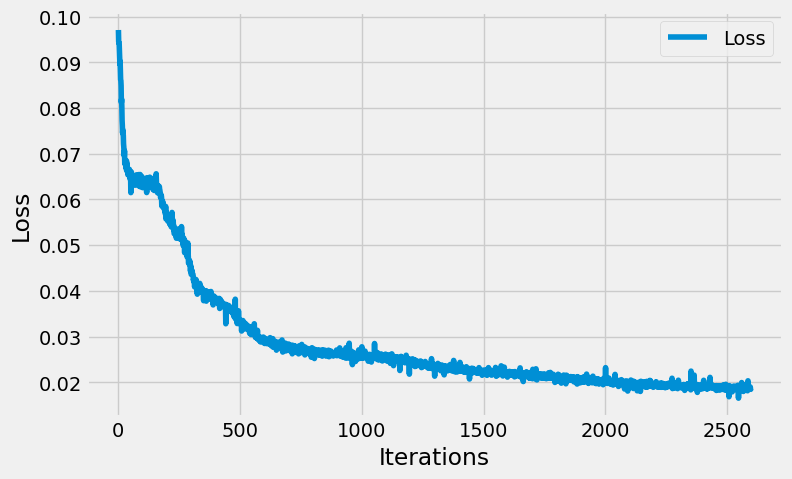

In [121]:
epochs = 200
outputs = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    for images, _ in loader:
        images = images.view(-1, 28 * 28).to(device)
        
        reconstructed = model(images)
        loss = loss_function(reconstructed, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

tensor(4)
tensor(7)
tensor(4)
tensor(7)
tensor(4)
tensor(7)
tensor(4)
tensor(7)
tensor(7)
tensor(4)


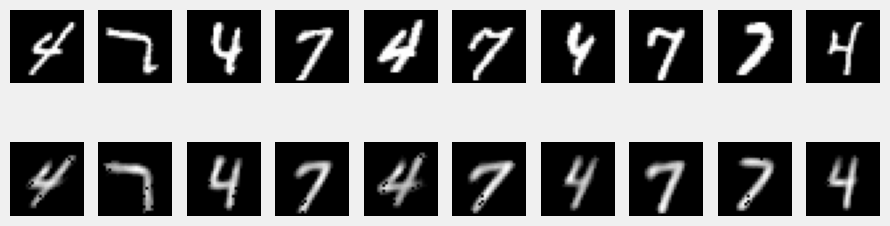

In [122]:
model.eval()
dataiter = iter(loader)
images, label = next(dataiter)

images = images.view(-1, 28 * 28).to(device)
reconstructed = model(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    print(label[i])
plt.show()

In [123]:
model.eval()
dataiter = iter(loader)
images, labels = next(dataiter)

# Flatten and move to device
images = images.view(-1, 28 * 28).to(device)
labels = labels.to(device)

# Get representation vector
with torch.no_grad():
    encoded_vectors = model.encoder(images)  # This is the latent space representation

# Convert to numpy for easier analysis
encoded_vectors_np = encoded_vectors.cpu().numpy()
labels_np = labels.cpu().numpy()

print("Encoded representation shape:", encoded_vectors_np.shape)  # Expected: (batch_size, 9)
print("Labels shape:", labels_np.shape) 

for i in range(5):
    print(f"Label: {labels_np[i]}, Representation Vector: {encoded_vectors_np[i]}")

Encoded representation shape: (1000, 9)
Labels shape: (1000,)
Label: 7, Representation Vector: [  7.6135445  10.931295  -16.49766     8.630092   -1.2328435  -4.0897655
   0.9107089   9.890376    4.659901 ]
Label: 4, Representation Vector: [ 7.529653    6.2608457  -8.2373495   4.7514167  -2.1475396  -2.5634925
  0.92295533  2.0622413   5.4555554 ]
Label: 4, Representation Vector: [  9.553734   10.33609   -13.100134    9.899442   -2.35854    -1.3592285
   2.9291415   4.383218    7.8062906]
Label: 7, Representation Vector: [ 7.2527685   7.6006746  -9.186948    4.9122305  -0.25416082 -1.91506
  0.8272181   6.8688216   5.294045  ]
Label: 7, Representation Vector: [ 4.5328     6.0057197 -6.995868   8.910645   2.8433976 -0.2797504
  4.0329943  6.1251764  5.728735 ]


In [124]:
from sklearn.model_selection import train_test_split

def preprocess(x,y):
    # 2: Split into train (80%) and remaining (20%)
    x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=22)

    # 3: Split remaining into val (10%) and test (10%)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=22)
    y_test = y_test.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)

    print("\nX-train shape: ", x_train.shape)
    print("Y-train shape: ", y_train.shape)

    print("\nX-val shape: ", x_val.shape)
    print("Y-val shape: ", y_val.shape)

    print("\nX-test shape: ", x_test.shape)
    print("Y-test shape: ", y_test.shape)
    return x_train, y_train, x_val, y_val, x_test, y_test
x_train, y_train, x_val, y_val, x_test, y_test = preprocess(encoded_vectors_np, labels_np)




X-train shape:  (800, 9)
Y-train shape:  (800, 1)

X-val shape:  (100, 9)
Y-val shape:  (100, 1)

X-test shape:  (100, 9)
Y-test shape:  (100, 1)


In [125]:
# Ensure y_train is a 1D array; if it's (n, 1), use ravel() or flatten()
y_train = y_train.ravel()

# Split X_train into two arrays: one for 4's and one for 7's
x_train_4 = x_train[y_train == 4]
x_train_7 = x_train[y_train == 7]


print("Shape of X_train for digit 4:", x_train_4.shape)
print("Shape of X_train for digit 7:", x_train_7.shape)

Shape of X_train for digit 4: (396, 9)
Shape of X_train for digit 7: (404, 9)


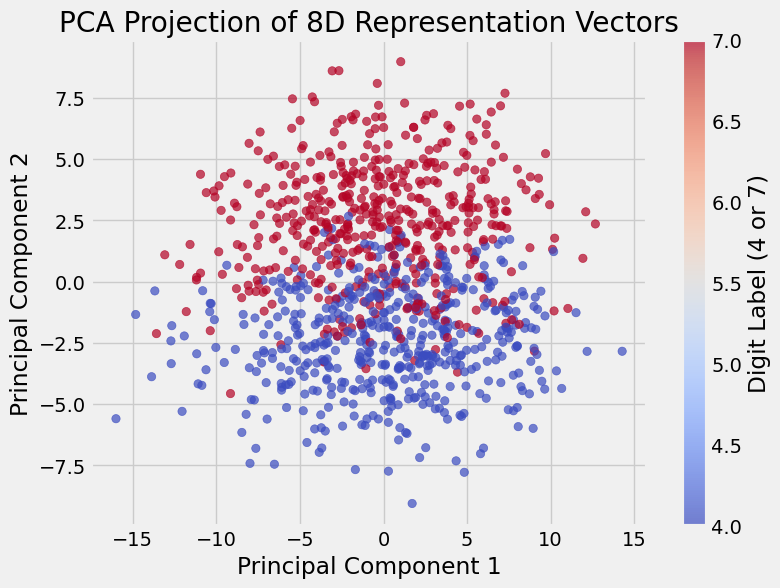

In [126]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assume `encoded_vectors_np` is your (batch_size, 8) representation matrix
pca = PCA(n_components=2)  # Reduce to 2D
reduced_vectors = pca.fit_transform(encoded_vectors_np)  # Apply PCA

# Scatter plot with labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=labels_np, cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label="Digit Label (4 or 7)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of 8D Representation Vectors")
plt.show()


In [127]:
from sklearn.metrics.pairwise import *
from sklearn.metrics import accuracy_score

# Using Kernel SVM to classify 4's and 7's
def Kernel_SVM(X,y):
    y = np.where(y == 4, -1, 1)
    g = 0.01
    u1 = 0.01
    u2 = 0.1
    K = polynomial_kernel(X, degree = 3, gamma = g)
    Y = np.diagflat(y)
    L = np.random.randn(X.shape[0],1)
    alpha = 0.0001

    for i in range(5000):
        dL = np.zeros((X.shape[0], 1))
        dL[L < 0] = -1
        grad = Y @ K @ Y @ L + 2 * u1 * (L.T @ y) * y - np.ones((X.shape[0], 1)) + np.ones((X.shape[0], 1)).T @ dL
        L = L - alpha * grad
        if i % 100 == 0:
            print(f"Iteration {i}")

    y_hat = K @ (L * y)
    # Indices of negative samples
    neg_idx = np.where(y.ravel() == -1)[0]
    # Indices of positive samples
    pos_idx = np.where(y.ravel() == 1)[0]

    neg_side = np.max(y_hat[neg_idx])
    pos_side = np.min(y_hat[pos_idx])

    b = (pos_side + neg_side) / 2
    y_hat = np.sign(K @ (L * y) + b)
    print("Accuracy: ", accuracy_score(y, y_hat))
    return K, L, y_hat, b

In [129]:
K, L, y_hat, b = Kernel_SVM(x_train,y_train)

Iteration 0


IndexError: boolean index did not match indexed array along dimension 1; dimension is 1 but corresponding boolean dimension is 800

In [104]:
# Prepare validation labels (convert to -1 and 1)
y_val_binary = np.where(y_val == 4, -1, 1)

# Compute the kernel between validation and training data using the same kernel parameters
g = 0.01  # Sames gamma used in training
K_val = polynomial_kernel(x_val, x_train, degree=3, gamma=g)

# Compute predictions on the validation set
y_val_pred = np.sign(K_val @ (L * y_train) + b)

# Evaluate the model on validation data
print("Validation Accuracy:", accuracy_score(y_val_binary, y_val_pred))

Validation Accuracy: 1.0


In [117]:
# Using MMD to classify
from sklearn.metrics.pairwise import rbf_kernel

def MMD_embedding(X, Y):
    gamma = 0.1
    KX = rbf_kernel(X, gamma=gamma)
    KY = rbf_kernel(Y, gamma=gamma)
    KXY= rbf_kernel(X, Y, gamma=gamma)
    
    print("Average value of X gaussian kernel in RKHS", np.average(KX))
    print("Average value of Y gaussian kernel in RKHS", np.average(KY))
    MMD = np.average(KX) + np.average(KY) - 2*np.average(KXY)
    print("Distance between X and Y", MMD)

MMD_embedding(x_train_4, x_train_7)

Average value of X gaussian kernel in RKHS 0.16001722
Average value of Y gaussian kernel in RKHS 0.097842656
Distance between X and Y 0.2459476049989462
